# Big Data Analytics

### by [Lorenzo Mario Amorosa](https://github.com/Lostefra)

This notebook contains code snippets useful to study Big Data Analytics in python (`pyspark`).

## 1. Installation

Install all the dependencies in Colab environment i.e. Apache Spark 2.4.7 with hadoop 2.6, Java 8 and Findspark to locate the spark in the system. Needed datasets are imported from Github.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.6.tgz
!tar xf spark-2.4.7-bin-hadoop2.6.tgz
!pip install -q findspark
print("Installation done")

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.6"

import findspark
findspark.init()

Installation done


In [ ]:
!git clone https://github.com/Lostefra/big-data-analytics-snippets.git
data_path = 'big-data-analytics-snippets/data/'

Cloning into 'big-data-analytics-snippets'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 38 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (38/38), done.


## 2. Spark structured API

#### DataFrameReader

`spark.read` is a `DataFrameReader` for reading data into a
DataFrame, with methods: `format` (CSV, JSON), `schema` (schema of the data), `option`.

Create a DataFrame from JSON file

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("test").getOrCreate()
source = data_path + "measurements.json"
df = spark.read.format("json").load(source)
df.show()

+------+-------------+----------+------------------+-------+
|  Code|Concentration|      Date|         Pollutant|Station|
+------+-------------+----------+------------------+-------+
| 88118|           79|2015-10-30|             Ozone| Rimini|
|927170|           25|2015-10-08|Particulate matter|Ravenna|
|190115|           59|2015-02-04|             Ozone| Rimini|
|697379|            0|2015-12-13|             Ozone| Cesena|
|887012|            5|2015-04-11|Particulate matter| Cesena|
|969127|           20|2015-10-19|           Benzene|Bologna|
|541554|           95|2015-10-16|  Nitrogen dioxide|Ravenna|
|848686|           63|2015-03-23|             Ozone|Ravenna|
|706846|           88|2015-05-02|Particulate matter|Ravenna|
|102991|           41|2015-04-02|Particulate matter| Rimini|
| 23433|           48|2015-01-06|           Benzene|Ravenna|
|709920|           14|2015-12-23|  Nitrogen dioxide| Rimini|
|138686|           97|2015-06-09|Particulate matter|Ravenna|
|445291|           46|20

#### Schema on read

The schema-on-read feature of Spark infers the following
schema

In [ ]:
df.schema

StructType(List(StructField(Code,LongType,true),StructField(Concentration,LongType,true),StructField(Date,StringType,true),StructField(Pollutant,StringType,true),StructField(Station,StringType,true)))

In [ ]:
df.printSchema()

root
 |-- Code: long (nullable = true)
 |-- Concentration: long (nullable = true)
 |-- Date: string (nullable = true)
 |-- Pollutant: string (nullable = true)
 |-- Station: string (nullable = true)



Column manipulation can be done through `col` or `column` functions. 

An expression in Spark is a set of transformations on
values of a data frame row and can be done through `expr`function.

In [ ]:
from pyspark.sql.functions import col, expr

e1 = expr("Concentration < 50 and Concentration > 10") # SQL-like
e2 = expr("Concentration * .9 + 0.01") # SQL-like
e3 = col("Concentration") *.9 + 0.01 # DataFrame

Row manipulation requires importing Row from `pyspark.sql`

In [ ]:
from pyspark.sql import Row
meas = Row(88118,"2015-10-30","Ozone","Rimini",79)
meas[0:2]

(88118, '2015-10-30')

#### StructType, StructField

Create DataFrames from rows

`StructType` defines schema, `StructField` defines a column of a given `Type`

In [ ]:
from pyspark.sql.types import StructField, StructType, StringType, LongType

AirSchema = StructType([
  StructField("Code",StringType(),False),
  StructField("Date",StringType(),True),
  StructField("Pollutant",StringType(),True),
  StructField("Station",StringType(),False, metadata={"station":"name"}),
  StructField("Concentration",LongType(),True)
])
meas1 = Row(88118,"2015-10-30","Ozone","Rimini",79)
meas2 = Row(927170,"2015-10-08","Particulate matter","Ravenna",25)
measurements = spark.createDataFrame([meas1, meas2], AirSchema)
measurements.show()

+------+----------+------------------+-------+-------------+
|  Code|      Date|         Pollutant|Station|Concentration|
+------+----------+------------------+-------+-------------+
| 88118|2015-10-30|             Ozone| Rimini|           79|
|927170|2015-10-08|Particulate matter|Ravenna|           25|
+------+----------+------------------+-------+-------------+



#### Select

The `select` method of DataFrame projects the frame onto
specified column names, possibly renamed using an
expression or the `alias` method

In [ ]:
df.select("Date", "Station", "Pollutant").show(2)

+----------+-------+------------------+
|      Date|Station|         Pollutant|
+----------+-------+------------------+
|2015-10-30| Rimini|             Ozone|
|2015-10-08|Ravenna|Particulate matter|
+----------+-------+------------------+
only showing top 2 rows



In [ ]:
df.select(expr("Date").alias("measure_date")).show(2)
df.select(expr("Date as measure_date")).show(2)

+------------+
|measure_date|
+------------+
|  2015-10-30|
|  2015-10-08|
+------------+
only showing top 2 rows

+------------+
|measure_date|
+------------+
|  2015-10-30|
|  2015-10-08|
+------------+
only showing top 2 rows



In [ ]:
df.select("*", expr("Concentration < 50 and Concentration > 10")).show(3)

+------+-------------+----------+------------------+-------+-----------------------------------------------+
|  Code|Concentration|      Date|         Pollutant|Station|((Concentration < 50) AND (Concentration > 10))|
+------+-------------+----------+------------------+-------+-----------------------------------------------+
| 88118|           79|2015-10-30|             Ozone| Rimini|                                          false|
|927170|           25|2015-10-08|Particulate matter|Ravenna|                                           true|
|190115|           59|2015-02-04|             Ozone| Rimini|                                          false|
+------+-------------+----------+------------------+-------+-----------------------------------------------+
only showing top 3 rows



#### SelectExpr

The `selectExpr` method allows for adding computed columns to
the output data frame using expressions

In [ ]:
df.selectExpr("*", "Concentration < 50 and Concentration > 10 as Interv").show(3)

+------+-------------+----------+------------------+-------+------+
|  Code|Concentration|      Date|         Pollutant|Station|Interv|
+------+-------------+----------+------------------+-------+------+
| 88118|           79|2015-10-30|             Ozone| Rimini| false|
|927170|           25|2015-10-08|Particulate matter|Ravenna|  true|
|190115|           59|2015-02-04|             Ozone| Rimini| false|
+------+-------------+----------+------------------+-------+------+
only showing top 3 rows



Aggregations in SQL expressions

In [ ]:
df.selectExpr("avg(Concentration)",
              "max(Concentration)",
              "count(distinct(Code))").show()

+------------------+------------------+--------------------+
|avg(Concentration)|max(Concentration)|count(DISTINCT Code)|
+------------------+------------------+--------------------+
|             48.34|               100|                 100|
+------------------+------------------+--------------------+



Constant columns can be added to the select expressions
using literals

In [ ]:
from pyspark.sql.functions import lit

df.select("*", lit("valid").alias("Validity")).show(3)

+------+-------------+----------+------------------+-------+--------+
|  Code|Concentration|      Date|         Pollutant|Station|Validity|
+------+-------------+----------+------------------+-------+--------+
| 88118|           79|2015-10-30|             Ozone| Rimini|   valid|
|927170|           25|2015-10-08|Particulate matter|Ravenna|   valid|
|190115|           59|2015-02-04|             Ozone| Rimini|   valid|
+------+-------------+----------+------------------+-------+--------+
only showing top 3 rows



#### WithColumn

The `withColumn` method of DataFrame adds a column or
replaces it using a column expression as source for its values (with a literal it adds a constant column)

In [ ]:
df.withColumn('Square conc', df.Concentration**2).show(2)

+------+-------------+----------+------------------+-------+-----------+
|  Code|Concentration|      Date|         Pollutant|Station|Square conc|
+------+-------------+----------+------------------+-------+-----------+
| 88118|           79|2015-10-30|             Ozone| Rimini|     6241.0|
|927170|           25|2015-10-08|Particulate matter|Ravenna|      625.0|
+------+-------------+----------+------------------+-------+-----------+
only showing top 2 rows



#### Drop

Remove a column with `drop` method

In [ ]:
df.drop("Concentration").show(2)

+------+----------+------------------+-------+
|  Code|      Date|         Pollutant|Station|
+------+----------+------------------+-------+
| 88118|2015-10-30|             Ozone| Rimini|
|927170|2015-10-08|Particulate matter|Ravenna|
+------+----------+------------------+-------+
only showing top 2 rows



#### Where, Filter

Filtering: `where` or `filter` with a SQL string or a column boolean expression

In [ ]:
df.where(col("Concentration") > 90)\
  .where(col("Date") >= '2015-10-16').show()

df.where((col("Concentration") > 90) & (col("Date") >= '2015-10-16')).show()
df.filter("Concentration > 90 and Date >= '2015-10-16'").show()

+------+-------------+----------+------------------+-------+
|  Code|Concentration|      Date|         Pollutant|Station|
+------+-------------+----------+------------------+-------+
|541554|           95|2015-10-16|  Nitrogen dioxide|Ravenna|
|720857|           92|2015-11-25|Particulate matter| Modena|
+------+-------------+----------+------------------+-------+

+------+-------------+----------+------------------+-------+
|  Code|Concentration|      Date|         Pollutant|Station|
+------+-------------+----------+------------------+-------+
|541554|           95|2015-10-16|  Nitrogen dioxide|Ravenna|
|720857|           92|2015-11-25|Particulate matter| Modena|
+------+-------------+----------+------------------+-------+

+------+-------------+----------+------------------+-------+
|  Code|Concentration|      Date|         Pollutant|Station|
+------+-------------+----------+------------------+-------+
|541554|           95|2015-10-16|  Nitrogen dioxide|Ravenna|
|720857|           92|

Boolean expressions and boolean columns (e.g. "monitor")


In [ ]:
from pyspark.sql.functions import instr

df.where("Station = 'Bologna'").show(1)
df.where(col("Station") == "Bologna").show(1)

df.where("Station <> 'Bologna'").show(1) # <> is inequality SQL operator
df.where(col("Station") != "Bologna").show(1)

conc_filter = col("Concentration") > 50
poll_filter = instr(df.Pollutant, "Particulate") >= 1
df.where(df.Station.isin("Bologna", "Rimini") &
         (conc_filter | poll_filter)).show(3)

loc_filter = col("Station").isin("Bologna", "Rimini")
df.withColumn("monitor", 
              loc_filter & (conc_filter | poll_filter))\
              .where("monitor").show(3)

+------+-------------+----------+---------+-------+
|  Code|Concentration|      Date|Pollutant|Station|
+------+-------------+----------+---------+-------+
|969127|           20|2015-10-19|  Benzene|Bologna|
+------+-------------+----------+---------+-------+
only showing top 1 row

+------+-------------+----------+---------+-------+
|  Code|Concentration|      Date|Pollutant|Station|
+------+-------------+----------+---------+-------+
|969127|           20|2015-10-19|  Benzene|Bologna|
+------+-------------+----------+---------+-------+
only showing top 1 row

+-----+-------------+----------+---------+-------+
| Code|Concentration|      Date|Pollutant|Station|
+-----+-------------+----------+---------+-------+
|88118|           79|2015-10-30|    Ozone| Rimini|
+-----+-------------+----------+---------+-------+
only showing top 1 row

+-----+-------------+----------+---------+-------+
| Code|Concentration|      Date|Pollutant|Station|
+-----+-------------+----------+---------+-------+


#### Distinc, Sort, OrderBy, Asc, Desc, Limit

Duplicate rows can be removed
from the output with the
`distinct` method of
DataFrame.

Sorting can be done with `sort` or `orderBy` methods, possibly applying `asc` or `desc` to columns.

It is possible to limit the number of output rows with `limit` method

In [ ]:
from pyspark.sql.functions import desc, asc

df.select("Station", "Pollutant")\
  .distinct()\
  .orderBy("Station", "Pollutant")\
  .show(2)

limited = df.sort(col("Pollutant"), 
                  col("Concentration").desc()).limit(2)
limited.show()

+-------+----------------+
|Station|       Pollutant|
+-------+----------------+
|Bologna|         Benzene|
|Bologna|Nitrogen dioxide|
+-------+----------------+
only showing top 2 rows

+------+-------------+----------+---------+-------+
|  Code|Concentration|      Date|Pollutant|Station|
+------+-------------+----------+---------+-------+
|403863|          100|2015-07-25|  Benzene|Ravenna|
|240104|           93|2015-05-16|  Benzene| Modena|
+------+-------------+----------+---------+-------+



#### Take, Collect

Collecting rows as list

In [ ]:
first3 = df.take(3)
all = df.collect()
print(type(first3), len(first3))
print(type(all), len(all))

<class 'list'> 3
<class 'list'> 100


#### Join

An inner join returns only rows that satifisfy the join condition (expressed with comparison operators)

In [ ]:
cities_source = data_path + "cities.csv"
cities = spark.read.csv(cities_source, header=True, inferSchema=True)
cities.show()

joinExpr = df["Station"] == cities["City"]
inner_join = df.join(cities, joinExpr)
inner_join.show(4)
print("Rows number:", len(inner_join.collect()))

+-------+------+----------+
|   City|  Area|Population|
+-------+------+----------+
| Rimini|135.71|    151200|
| Cesena|249.47|     97190|
|Bologna|140.86|    391525|
|Ravenna|241.75|    158058|
| Modena|183.19|    186741|
|Ferrara|405.16|    132195|
+-------+------+----------+

+------+-------------+----------+------------------+-------+-------+------+----------+
|  Code|Concentration|      Date|         Pollutant|Station|   City|  Area|Population|
+------+-------------+----------+------------------+-------+-------+------+----------+
| 88118|           79|2015-10-30|             Ozone| Rimini| Rimini|135.71|    151200|
|927170|           25|2015-10-08|Particulate matter|Ravenna|Ravenna|241.75|    158058|
|190115|           59|2015-02-04|             Ozone| Rimini| Rimini|135.71|    151200|
|697379|            0|2015-12-13|             Ozone| Cesena| Cesena|249.47|     97190|
+------+-------------+----------+------------------+-------+-------+------+----------+
only showing top 4 rows

An outer join contains also those rows that did not match the comparison. They are put in combination with null values. There can be done left and right outer join as well

In [ ]:
outer_join = df.join(cities, joinExpr, "outer")
outer_join.show(4)
print("Rows number:", len(outer_join.collect())) # 101 because of 'Ferrara' city

+------+-------------+----------+------------------+-------+------+------+----------+
|  Code|Concentration|      Date|         Pollutant|Station|  City|  Area|Population|
+------+-------------+----------+------------------+-------+------+------+----------+
|753053|           47|2015-02-08|             Ozone| Modena|Modena|183.19|    186741|
|233603|           49|2015-07-16|  Nitrogen dioxide| Modena|Modena|183.19|    186741|
|928968|           10|2015-04-17|Particulate matter| Modena|Modena|183.19|    186741|
|100364|           81|2015-03-20|           Benzene| Modena|Modena|183.19|    186741|
+------+-------------+----------+------------------+-------+------+------+----------+
only showing top 4 rows

Rows number: 101


In [ ]:
# Condition: df["Station"] == cities["City"]
outer_join = df.join(cities, joinExpr, "right_outer")
print("Rows number right outer join:", len(outer_join.collect())) # 101 because of 'Ferrara' city
outer_join = df.join(cities, joinExpr, "left_outer")
print("Rows number left outer join:", len(outer_join.collect())) # 100, like inner join

Rows number right outer join: 101
Rows number left outer join: 100


A left semi join contains the rows of T1 which satisfy the
join expression.

A left anti join contains the rows of T1 whith do not satisfy
the join expression.

A cartesian or cross product is equivalent to a join with a
True join expression

In [ ]:
cities.join(df, joinExpr, "left_semi").show() # No 'Ferrara'
cities.join(df, joinExpr, "left_anti").show() # Only 'Ferrara'
#cross_join = cities.join(df, joinExpr, "cross")
cross_join = cities.crossJoin(df)
print("Rows number cross join:", len(cross_join.collect()))

+-------+------+----------+
|   City|  Area|Population|
+-------+------+----------+
| Rimini|135.71|    151200|
| Cesena|249.47|     97190|
|Bologna|140.86|    391525|
|Ravenna|241.75|    158058|
| Modena|183.19|    186741|
+-------+------+----------+

+-------+------+----------+
|   City|  Area|Population|
+-------+------+----------+
|Ferrara|405.16|    132195|
+-------+------+----------+

Rows number cross join: 600


#### Aggregations

In [ ]:
from pyspark.sql.functions import count, countDistinct, first, last, min, max, sum, sumDistinct, avg

cities.select(count("City"),
              countDistinct("City"),
              first("City"),
              last("City"),
              min("Population"),
              max("Population"),
              avg("Population"),
              sum("Area"),
              sumDistinct("Area")).show()

+-----------+--------------------+-----------+----------+---------------+---------------+---------------+---------+------------------+
|count(City)|count(DISTINCT City)|first(City)|last(City)|min(Population)|max(Population)|avg(Population)|sum(Area)|sum(DISTINCT Area)|
+-----------+--------------------+-----------+----------+---------------+---------------+---------------+---------+------------------+
|          6|                   6|     Rimini|   Ferrara|          97190|         391525|       186151.5|  1356.14|           1356.14|
+-----------+--------------------+-----------+----------+---------------+---------------+---------------+---------+------------------+



#### Variance, covariance, correlation

Both sample and population

In [ ]:
from pyspark.sql.functions import var_pop, var_samp, corr, covar_pop, covar_samp

df.select(var_samp("Concentration"), var_pop("Concentration")).show()

conc_pop = df.join(cities, df["Station"] == cities["City"])
conc_dens = conc_pop.withColumn("Density",
                                conc_pop["Population"]/conc_pop["Area"])
conc_dens.select(corr("Density", "Concentration"),
                 covar_samp("Density", "Concentration"),
                 covar_pop("Density", "Concentration")).show()

+-----------------------+----------------------+
|var_samp(Concentration)|var_pop(Concentration)|
+-----------------------+----------------------+
|      903.3175757575759|     894.2844000000001|
+-----------------------+----------------------+

+----------------------------+----------------------------------+---------------------------------+
|corr(Density, Concentration)|covar_samp(Density, Concentration)|covar_pop(Density, Concentration)|
+----------------------------+----------------------------------+---------------------------------+
|         0.05278344955861994|                1413.1404856685933|               1399.0090808119076|
+----------------------------+----------------------------------+---------------------------------+



#### Agg, Collect_set, Collect_list

Aggregation as collection of values of columns into sets or lists

In [ ]:
from pyspark.sql.functions import collect_set, collect_list

df.agg(collect_set("Station"), collect_list("Concentration")).show() # ok also df.select

+--------------------+---------------------------+
|collect_set(Station)|collect_list(Concentration)|
+--------------------+---------------------------+
|[Bologna, Modena,...|       [79, 25, 59, 0, 5...|
+--------------------+---------------------------+



#### GroupBy

Aggregations by groups

In [ ]:
df.groupBy("Station").count().show()

df.groupBy("Station", "Pollutant").agg(avg("Concentration").alias("Avg conc"),
                                       var_samp("Concentration").alias("Var conc"),
                                       count("*")).show(3)

+-------+-----+
|Station|count|
+-------+-----+
| Modena|   19|
|Bologna|   24|
| Cesena|   17|
| Rimini|   16|
|Ravenna|   24|
+-------+-----+

+-------+------------------+-----------------+-----------------+--------+
|Station|         Pollutant|         Avg conc|         Var conc|count(1)|
+-------+------------------+-----------------+-----------------+--------+
|Ravenna|  Nitrogen dioxide|             59.5|           1047.0|       4|
|Bologna|Particulate matter|            59.75|          1022.25|       4|
| Rimini|             Ozone|60.42857142857143|514.6190476190476|       7|
+-------+------------------+-----------------+-----------------+--------+
only showing top 3 rows



#### Window: PartitionBy, OrderBy, RowsBetween, RangeBetween

Functions are applicable to sliding windows, defined by window
specifications, which set grouping (`partitionBy`), ordering (`orderBy`) and framing (`rowsBetween`, `rangeBetween`).

In the example: find the average concentration by station in Bologna or Rimini
in sliding windows of size 5 (using the previous 4 related rows)

In [ ]:
from pyspark.sql.window import Window

dfrb = df.where("Station = 'Rimini' or Station = 'Bologna'")
win = Window.partitionBy("Station").orderBy(asc("Date")).rowsBetween(-4, 0)
dfrb.select(col("Station"), col("Date"),
            avg(col("Concentration")).over(win).alias("Avg conc")).show(3)

+-------+----------+--------+
|Station|      Date|Avg conc|
+-------+----------+--------+
|Bologna|2015-01-29|    54.0|
|Bologna|2015-03-10|    75.5|
|Bologna|2015-04-20|    70.0|
+-------+----------+--------+
only showing top 3 rows



#### Rollup

The rollup operation computes aggregates in groups defined by
a set of columns, and a chain of its subsets (for example,
{Pollutant, Station}, {Pollutant}, { } (empty set))

In [ ]:
df.rollup("Pollutant", "Station")\
  .agg(max("Concentration"))\
  .orderBy("Station", "Pollutant").show(10)

+------------------+-------+------------------+
|         Pollutant|Station|max(Concentration)|
+------------------+-------+------------------+
|              null|   null|               100|
|           Benzene|   null|               100|
|  Nitrogen dioxide|   null|                97|
|             Ozone|   null|                98|
|Particulate matter|   null|                97|
|           Benzene|Bologna|                73|
|  Nitrogen dioxide|Bologna|                70|
|             Ozone|Bologna|                98|
|Particulate matter|Bologna|                97|
|           Benzene| Cesena|                72|
+------------------+-------+------------------+
only showing top 10 rows



#### Cube

The cube operation computes aggregates in all groups defined
by all subsets of a set of columns

In [ ]:
df.cube("Pollutant", "Station")\
  .agg(max("Concentration"))\
  .orderBy("Station", "Pollutant").show(11)

+------------------+-------+------------------+
|         Pollutant|Station|max(Concentration)|
+------------------+-------+------------------+
|              null|   null|               100|
|           Benzene|   null|               100|
|  Nitrogen dioxide|   null|                97|
|             Ozone|   null|                98|
|Particulate matter|   null|                97|
|              null|Bologna|                98|
|           Benzene|Bologna|                73|
|  Nitrogen dioxide|Bologna|                70|
|             Ozone|Bologna|                98|
|Particulate matter|Bologna|                97|
|              null| Cesena|                83|
+------------------+-------+------------------+
only showing top 11 rows



#### String case

In [ ]:
from pyspark.sql.functions import initcap, lower, upper

df.select(initcap(col("Pollutant")),
          lower(col("Pollutant")),
          upper(col("Pollutant"))).show(1)

+------------------+----------------+----------------+
|initcap(Pollutant)|lower(Pollutant)|upper(Pollutant)|
+------------------+----------------+----------------+
|             Ozone|           ozone|           OZONE|
+------------------+----------------+----------------+
only showing top 1 row



#### Space trimming

In [ ]:
from pyspark.sql.functions import ltrim, rtrim, trim
df.select(ltrim(lit(" Ozone ")).alias("lt")).show(1)
df.select(rtrim(lit(" Ozone ")).alias("rt")).show(1)
df.select(trim(lit(" Ozone ")).alias("t")).show(1)

+------+
|    lt|
+------+
|Ozone |
+------+
only showing top 1 row

+------+
|    rt|
+------+
| Ozone|
+------+
only showing top 1 row

+-----+
|    t|
+-----+
|Ozone|
+-----+
only showing top 1 row



#### Character padding

In [ ]:
from pyspark.sql.functions import lpad, rpad
df.select(lpad(lit("Ozone"), 10, "-=").alias("lp")).show(1)
df.select(rpad(lit("Ozone"), 10, "-=").alias("rp")).show(1)

+----------+
|        lp|
+----------+
|-=-=-Ozone|
+----------+
only showing top 1 row

+----------+
|        rp|
+----------+
|Ozone-=-=-|
+----------+
only showing top 1 row



#### Regular expressions

`regexp_extract` finds and extracts into a new column all
unique occurrences of virus

In [ ]:
from pyspark.sql.functions import regexp_extract, length

source_tweets = data_path + "reuters_health.txt"
TweetSchema = StructType([
  StructField("Tweet Text", StringType(), True)
])
h_news = spark.read.format("text").schema(TweetSchema).load(source_tweets)
re = "H[1-9]N[1-9]| +flu +|^flu +| +flu$"
h_news.select(regexp_extract(col("Tweet Text"), re, 0)\
  .alias("Flu text")).where(length("Flu text") > 0)\
  .distinct().show()

+--------+
|Flu text|
+--------+
|    H7N3|
|    flu |
|    H7N9|
|    H1N1|
|    H5N1|
|    H5N8|
|    H5N6|
+--------+



#### Date, Time, Date operations, Date intervals and conversions

In [ ]:
from pyspark.sql.functions import current_date, current_timestamp, date_add, date_sub, datediff, months_between, to_date, to_timestamp

spark.range(2)\
  .withColumn("curr date", current_date())\
  .withColumn("curr time", current_timestamp())\
  .withColumn("Yesterday", date_sub(col("curr date"), 1))\
  .withColumn("Tomorrow", date_add(col("curr date"), 1))\
  .withColumn("datediff", datediff(col("Tomorrow"), col("Yesterday")))\
  .withColumn("months_between", months_between(col("Tomorrow"), col("Yesterday")))\
  .withColumn("to_timestamp", to_timestamp(lit("2020-20-11 10:00:01"), "yyyy-dd-MM hh:mm:ss"))\
  .withColumn("to_date", to_date(lit("2020-12-20"), "yyyy-MM-dd"))\
  .withColumn("to_date_null", to_date(lit("2020-13-20"), "yyyy-MM-dd"))\
  .show()

+---+----------+--------------------+----------+----------+--------+--------------+-------------------+----------+------------+
| id| curr date|           curr time| Yesterday|  Tomorrow|datediff|months_between|       to_timestamp|   to_date|to_date_null|
+---+----------+--------------------+----------+----------+--------+--------------+-------------------+----------+------------+
|  0|2021-02-02|2021-02-02 16:25:...|2021-02-01|2021-02-03|       2|    0.06451613|2020-11-20 10:00:01|2020-12-20|        null|
|  1|2021-02-02|2021-02-02 16:25:...|2021-02-01|2021-02-03|       2|    0.06451613|2020-11-20 10:00:01|2020-12-20|        null|
+---+----------+--------------------+----------+----------+--------+--------------+-------------------+----------+------------+



#### Null values

Null values are inserted in rows as `None` and can be filled with DataFrame method `na.fill` or eliminated with `na.drop`

In [ ]:
r1 = Row(1,"2019-10-01","Rome",None)
r2 = Row(2,"2019-10-02","Milan",15)
temp_schema = StructType([StructField("Id",StringType(),False),
                          StructField("Date",StringType(),True),
                          StructField("City",StringType(),True),
                          StructField("Temperature",LongType(),True)])
air_temp = spark.createDataFrame([r1, r2], temp_schema)

air_temp.show()
air_temp.na.fill({"Temperature":10}).show()
air_temp.na.drop("any").show()
air_temp.na.drop("all").show()


+---+----------+-----+-----------+
| Id|      Date| City|Temperature|
+---+----------+-----+-----------+
|  1|2019-10-01| Rome|       null|
|  2|2019-10-02|Milan|         15|
+---+----------+-----+-----------+

+---+----------+-----+-----------+
| Id|      Date| City|Temperature|
+---+----------+-----+-----------+
|  1|2019-10-01| Rome|         10|
|  2|2019-10-02|Milan|         15|
+---+----------+-----+-----------+

+---+----------+-----+-----------+
| Id|      Date| City|Temperature|
+---+----------+-----+-----------+
|  2|2019-10-02|Milan|         15|
+---+----------+-----+-----------+

+---+----------+-----+-----------+
| Id|      Date| City|Temperature|
+---+----------+-----+-----------+
|  1|2019-10-01| Rome|       null|
|  2|2019-10-02|Milan|         15|
+---+----------+-----+-----------+



#### Complex values

Complex values as `struct` columns, created by parenthesised expressions.

Refer to components of struct columns either using dot notation
in expressions, or using the `getField` method of columns

In [ ]:
from pyspark.sql.functions import struct

at1 = air_temp.selectExpr("(Date,City) as TimeLoc", "Temperature")
at2 = air_temp.select(struct("Date","City").alias("TimeLoc"), "Temperature")

at1.show()
at2.show()
at1.printSchema()
at2.printSchema()

at1.where("TimeLoc.City = 'Milan'")\
  .select(col("TimeLoc").getField("Date"), "Temperature")\
  .show()

+-------------------+-----------+
|            TimeLoc|Temperature|
+-------------------+-----------+
| [2019-10-01, Rome]|       null|
|[2019-10-02, Milan]|         15|
+-------------------+-----------+

+-------------------+-----------+
|            TimeLoc|Temperature|
+-------------------+-----------+
| [2019-10-01, Rome]|       null|
|[2019-10-02, Milan]|         15|
+-------------------+-----------+

root
 |-- TimeLoc: struct (nullable = false)
 |    |-- Date: string (nullable = true)
 |    |-- City: string (nullable = true)
 |-- Temperature: long (nullable = true)

root
 |-- TimeLoc: struct (nullable = false)
 |    |-- Date: string (nullable = true)
 |    |-- City: string (nullable = true)
 |-- Temperature: long (nullable = true)

+------------+-----------+
|TimeLoc.Date|Temperature|
+------------+-----------+
|  2019-10-02|         15|
+------------+-----------+



#### Regular expression groups

In [ ]:
# (id) | (timestamp) | (text) (url)
re = "^([0-9]+)\|([a-zA-Z0-9:+ ]+)\|(.+)( http://reut.rs.*)$"
h_news_tw = h_news.select(
    regexp_extract(col("Tweet Text"), re, 2).alias("Time"),
    regexp_extract(col("Tweet Text"), re, 3).alias("Tweet"))
h_news_tw.show(2)

+--------------------+--------------------+
|                Time|               Tweet|
+--------------------+--------------------+
|Thu Apr 09 21:40:...|Los Angeles close...|
|Thu Apr 09 21:24:...|U.S. cuts poultry...|
+--------------------+--------------------+
only showing top 2 rows



#### Split, Explode

It can be used `split` to transform columns values to array and `explode` to put each value of an array on a separate row, duplicating the
values of the other columns, useful to transform transaction to normal form

In [ ]:
from pyspark.sql.functions import split, explode

h_news_words = h_news_tw.select("Time",
                                split(col("Tweet"), " ").alias("Tweet words"))
h_news_words.show(4)
h_news_words.select("Time",
                    explode(col("Tweet words")).alias("Word")).show(4)

+--------------------+--------------------+
|                Time|         Tweet words|
+--------------------+--------------------+
|Thu Apr 09 21:40:...|[Los, Angeles, cl...|
|Thu Apr 09 21:24:...|[U.S., cuts, poul...|
|Thu Apr 09 21:04:...|[Fears, over, Rou...|
|Thu Apr 09 19:49:...|[Liberia, watchdo...|
+--------------------+--------------------+
only showing top 4 rows

+--------------------+-------+
|                Time|   Word|
+--------------------+-------+
|Thu Apr 09 21:40:...|    Los|
|Thu Apr 09 21:40:...|Angeles|
|Thu Apr 09 21:40:...| closes|
|Thu Apr 09 21:40:...|    500|
+--------------------+-------+
only showing top 4 rows



#### Map

Function `create_map` creates key-value pairs (map) from columns, which can be accessed with expressions and square
brackets or columns and square brackets

In [ ]:
from pyspark.sql.functions import create_map

exp_poll = df.select(create_map(col("Date"),
                                col("Concentration")).alias("DateConc"))
exp_poll.show(3, False) # False: don't truncate

exp_poll.selectExpr("DateConc['2015-10-30']").show(2)
exp_poll.select(col("DateConc")['2015-10-30']).show(2)

+------------------+
|DateConc          |
+------------------+
|[2015-10-30 -> 79]|
|[2015-10-08 -> 25]|
|[2015-02-04 -> 59]|
+------------------+
only showing top 3 rows

+--------------------+
|DateConc[2015-10-30]|
+--------------------+
|                  79|
|                null|
+--------------------+
only showing top 2 rows

+--------------------+
|DateConc[2015-10-30]|
+--------------------+
|                  79|
|                null|
+--------------------+
only showing top 2 rows



## 3. MLlib

#### Vector

In both supervised and unsupervised machine learning,
features are encoded as vectors, dense or sparse

In [ ]:
from pyspark.ml.linalg import Vectors

v = Vectors.dense(3.141, 2.718)
v

DenseVector([3.141, 2.718])

In [ ]:
# total element, positions, values
s = Vectors.sparse(3, [1, 2], [3.141, 2.718])
s

SparseVector(3, {1: 3.141, 2: 2.718})

#### Wine

In [ ]:
from pyspark.sql.types import IntegerType, DoubleType

wine_schema = StructType([
  StructField("Class",IntegerType(),True),
  StructField("Alcohol",DoubleType(),True),
  StructField("Malic acid",DoubleType(),True),
  StructField("Ash",DoubleType(),True),
  StructField("Alcalinity of ash",DoubleType(),True),
  StructField("Magnesium",DoubleType(),True),
  StructField("Total phenols",DoubleType(),True),
  StructField("Flavonoids",DoubleType(),True),
  StructField("Nonflavonoid phenols",DoubleType(),True),
  StructField("Proanthocyanins",DoubleType(),True),
  StructField("Color intensity",DoubleType(),True),
  StructField("Hue",DoubleType(),True),
  StructField("OD280/OD315 of diluted wines",DoubleType(),True),
  StructField("Proline",DoubleType(),True)
])

wine = spark.read.format("csv")\
  .schema(wine_schema)\
  .option("sep", ",")\
  .option("path", data_path + "wine.data").load()

wine.show(3)

+-----+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+
|Class|Alcohol|Malic acid| Ash|Alcalinity of ash|Magnesium|Total phenols|Flavonoids|Nonflavonoid phenols|Proanthocyanins|Color intensity| Hue|OD280/OD315 of diluted wines|Proline|
+-----+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+
|    1|  14.23|      1.71|2.43|             15.6|    127.0|          2.8|      3.06|                0.28|           2.29|           5.64|1.04|                        3.92| 1065.0|
|    1|   13.2|      1.78|2.14|             11.2|    100.0|         2.65|      2.76|                0.26|           1.28|           4.38|1.05|                         3.4| 1050.0|
|    1|  13.16|      2.36|2.67|             18.6|    101.0|          2.8|      3.24|                

Generate features using an R model formula. Features contains all attributes apart from class. Alternatively, `VectorAssembler` can be used for this purpose

In [ ]:
from pyspark.ml.feature import RFormula

rf = RFormula(formula="class ~ .")
rf_fit = rf.fit(wine)
rf_transfd = rf_fit.transform(wine)
rf_transfd.printSchema()

root
 |-- Class: integer (nullable = true)
 |-- Alcohol: double (nullable = true)
 |-- Malic acid: double (nullable = true)
 |-- Ash: double (nullable = true)
 |-- Alcalinity of ash: double (nullable = true)
 |-- Magnesium: double (nullable = true)
 |-- Total phenols: double (nullable = true)
 |-- Flavonoids: double (nullable = true)
 |-- Nonflavonoid phenols: double (nullable = true)
 |-- Proanthocyanins: double (nullable = true)
 |-- Color intensity: double (nullable = true)
 |-- Hue: double (nullable = true)
 |-- OD280/OD315 of diluted wines: double (nullable = true)
 |-- Proline: double (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

train, test = rf_transfd.randomSplit([0.7, 0.3])
in_train = train.selectExpr("features", "cast(class as double) as label") # dataset: features, label

tree = DecisionTreeClassifier()
print(tree.explainParams())
tree_mod = tree.fit(in_train)
tree_mod.transform(in_train).select("label", "prediction").show(3)
# dataset after transform: features|label|rawPrediction|probability|prediction|

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree.

#### Wine Quality

##### A - Decision Tree

In [ ]:
wineq = spark.read.format("csv")\
  .option("sep", ";")\
  .option("header", "True")\
  .option("inferSchema", "True")\
  .option("path", data_path + "winequality-red.csv").load()

wineq.printSchema()

# create 'features'
rfwq = RFormula(formula="quality ~ .")
rf_fit_wq = rfwq.fit(wineq)
rf_transfd_wq = rf_fit_wq.transform(wineq)

# create and fit Decision Tree
train_wq, test_wq = rf_transfd_wq.randomSplit([0.7, 0.3])
in_train_wq = train_wq.selectExpr("features", "label")
tree_wq = DecisionTreeClassifier() 
tree_mod_wq = tree_wq.fit(in_train_wq)
tree_mod_wq.transform(in_train_wq).select("label", "prediction").show(4)


root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)

+-----+----------+
|label|prediction|
+-----+----------+
|  4.0|       6.0|
|  6.0|       6.0|
|  7.0|       7.0|
|  6.0|       6.0|
+-----+----------+
only showing top 4 rows



##### B - LinearRegression

In [ ]:
wineq_schema = StructType([\
    StructField("FAcid",DoubleType(),True),    # 1 - fixed acidity			  
    StructField("VAcid",DoubleType(),True),    # 2 - volatile acidity			  
    StructField("Citr",DoubleType(),True),     # 3 - citric acid			  
    StructField("ReSug",DoubleType(),True),    # 4 - residual sugar			  
    StructField("Chlo",DoubleType(),True),     # 5 - chlorides				  
    StructField("FrSO2",DoubleType(),True),    # 6 - free sulfur dioxide		  
    StructField("TSO2",DoubleType(),True),     # 7 - total sulfur dioxide		  
    StructField("Den",DoubleType(),True),      # 8 - density				  
    StructField("pH",DoubleType(),True),       # 9 - pH				  
    StructField("Sulph",DoubleType(),True),    # 10 - sulphates			  
    StructField("Alc",DoubleType(),True),      # 11 - alcohol				  
    StructField("Qual",DoubleType(),True)])    # 12 - quality (score between 0 and 10)
wineq = spark.read.format("csv").option("header", "True").option("sep", ";")\
        .schema(wineq_schema)\
        .load(data_path + "winequality-red.csv")
wineq.show(3)

+-----+-----+----+-----+-----+-----+----+------+----+-----+---+----+
|FAcid|VAcid|Citr|ReSug| Chlo|FrSO2|TSO2|   Den|  pH|Sulph|Alc|Qual|
+-----+-----+----+-----+-----+-----+----+------+----+-----+---+----+
|  7.4|  0.7| 0.0|  1.9|0.076| 11.0|34.0|0.9978|3.51| 0.56|9.4| 5.0|
|  7.8| 0.88| 0.0|  2.6|0.098| 25.0|67.0|0.9968| 3.2| 0.68|9.8| 5.0|
|  7.8| 0.76|0.04|  2.3|0.092| 15.0|54.0| 0.997|3.26| 0.65|9.8| 5.0|
+-----+-----+----+-----+-----+-----+----+------+----+-----+---+----+
only showing top 3 rows



In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

vecAssembler = VectorAssembler(outputCol="features")
vecAssembler.setInputCols(["FAcid","VAcid","Citr","ReSug","Chlo","FrSO2","TSO2","Den","pH","Sulph","Alc"])
v_wineq = vecAssembler.transform(wineq)
v_wineq.show(3, False)

+-----+-----+----+-----+-----+-----+----+------+----+-----+---+----+-------------------------------------------------------+
|FAcid|VAcid|Citr|ReSug|Chlo |FrSO2|TSO2|Den   |pH  |Sulph|Alc|Qual|features                                               |
+-----+-----+----+-----+-----+-----+----+------+----+-----+---+----+-------------------------------------------------------+
|7.4  |0.7  |0.0 |1.9  |0.076|11.0 |34.0|0.9978|3.51|0.56 |9.4|5.0 |[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4] |
|7.8  |0.88 |0.0 |2.6  |0.098|25.0 |67.0|0.9968|3.2 |0.68 |9.8|5.0 |[7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8] |
|7.8  |0.76 |0.04|2.3  |0.092|15.0 |54.0|0.997 |3.26|0.65 |9.8|5.0 |[7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8]|
+-----+-----+----+-----+-----+-----+----+------+----+-----+---+----+-------------------------------------------------------+
only showing top 3 rows



In [ ]:
normaliser = StandardScaler(inputCol="features", outputCol="normFeatures")
normModel = normaliser.fit(v_wineq)
wineq_norm = normModel.transform(v_wineq)
wineq_norm.show(3)

+-----+-----+----+-----+-----+-----+----+------+----+-----+---+----+--------------------+--------------------+
|FAcid|VAcid|Citr|ReSug| Chlo|FrSO2|TSO2|   Den|  pH|Sulph|Alc|Qual|            features|        normFeatures|
+-----+-----+----+-----+-----+-----+----+------+----+-----+---+----+--------------------+--------------------+
|  7.4|  0.7| 0.0|  1.9|0.076| 11.0|34.0|0.9978|3.51| 0.56|9.4| 5.0|[7.4,0.7,0.0,1.9,...|[4.25019565141442...|
|  7.8| 0.88| 0.0|  2.6|0.098| 25.0|67.0|0.9968| 3.2| 0.68|9.8| 5.0|[7.8,0.88,0.0,2.6...|[4.47993595689628...|
|  7.8| 0.76|0.04|  2.3|0.092| 15.0|54.0| 0.997|3.26| 0.65|9.8| 5.0|[7.8,0.76,0.04,2....|[4.47993595689628...|
+-----+-----+----+-----+-----+-----+----+------+----+-----+---+----+--------------------+--------------------+
only showing top 3 rows



In [ ]:
from pyspark.ml.regression import LinearRegression

inp_wineq_norm = wineq_norm.select(["normFeatures", "Qual"])
train, test = inp_wineq_norm.randomSplit([0.67, 0.33])
lambda_pars = [1., .1, .01, .001, .0001, .00001, .000001]
weights = list()
intercepts = list()
RMSE = list() # root mean square error
for lambda_par in lambda_pars:
    ridge = LinearRegression(featuresCol = "normFeatures", labelCol='Qual', maxIter=100, regParam=lambda_par, elasticNetParam=0.0)
    ridge_mod = ridge.fit(train)
    eval_res = ridge_mod.evaluate(test)
    RMSE.append(eval_res.rootMeanSquaredError)
    mod_weights = ridge_mod.coefficients.toArray()
    weights.append(mod_weights)
    intercepts.append(ridge_mod.intercept)

In [ ]:
print('{:18}'.format("RMSE"), "lambda") 
for i in range(len(RMSE)):   
    print(RMSE[i], lambda_pars[i])

RMSE               lambda
0.7025212383836893 1.0
0.6732894267318601 0.1
0.6740968018042259 0.01
0.6744774762868831 0.001
0.674521827838904 0.0001
0.6745263351502185 1e-05
0.674526786614456 1e-06


In [ ]:
n_weights = len(weights[0])
ordered_idx = sorted(zip(range(n_weights), weights[2]), key=lambda x: -abs(x[1]))
for (a,b) in ordered_idx:
    print(wineq.columns[a])

Alc
VAcid
Sulph
TSO2
Chlo
pH
Citr
FAcid
FrSO2
Den
ReSug


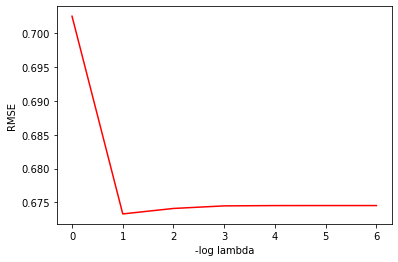

In [ ]:
import matplotlib.pyplot as plt

x = range(len(RMSE))
plt.plot(x, RMSE, 'r')
plt.xlabel('-log lambda')
plt.ylabel('RMSE')
plt.show()

##### C - GBT Regressor

In [ ]:
inp_wineq = v_wineq.select(["features", "Qual"])
inp_wineq.show(3)

+--------------------+----+
|            features|Qual|
+--------------------+----+
|[7.4,0.7,0.0,1.9,...| 5.0|
|[7.8,0.88,0.0,2.6...| 5.0|
|[7.8,0.76,0.04,2....| 5.0|
+--------------------+----+
only showing top 3 rows



In [ ]:
from pyspark.ml.regression import GBTRegressor

train, test = inp_wineq.randomSplit([0.67, 0.33])
gb_tree = GBTRegressor(featuresCol = 'features', # Gradient boosted tree regressor 
                       labelCol = 'Qual', 
                       maxIter=100, 
                       maxDepth=5, 
                       subsamplingRate=0.5, 
                       stepSize=0.1)
gb_tree_mod = gb_tree.fit(train)
gb_tree_preds = gb_tree_mod.transform(test)
gb_tree_preds.select('prediction', 'Qual').show(3)

+-----------------+----+
|       prediction|Qual|
+-----------------+----+
|6.589831474531471| 7.0|
|5.749821204132721| 6.0|
|7.591536065399672| 7.0|
+-----------------+----+
only showing top 3 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

gb_tree_eval = RegressionEvaluator(
                    labelCol="Qual", 
                    predictionCol="prediction", 
                    metricName="rmse")
RMSE = gb_tree_eval.evaluate(gb_tree_preds)

gb_tree_eval = RegressionEvaluator(
                    labelCol="Qual", 
                    predictionCol="prediction", 
                    metricName="r2")
R2 = gb_tree_eval.evaluate(gb_tree_preds)

print("RMSE (testing): ", RMSE)
print("R Squared (testing):", R2)

RMSE (testing):  0.7697892515824251
R Squared (testing): 0.1058223979645515


##### D - Data Exploration

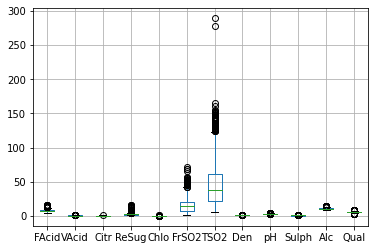

In [ ]:
wineq_pd = wineq.toPandas()
wineq_pd.boxplot()

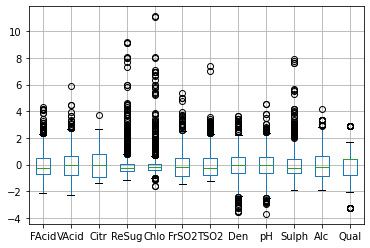

In [ ]:
# normalise the data
desc_stats = wineq_pd.describe()
wineq_norm = wineq_pd.copy()
for c in desc_stats.columns:
  mean = desc_stats.loc['mean', c]
  sd = desc_stats.loc['std', c]
  wineq_norm.loc[:, c] = (wineq_pd.loc[:, c] - mean) / sd
wineq_norm.boxplot()

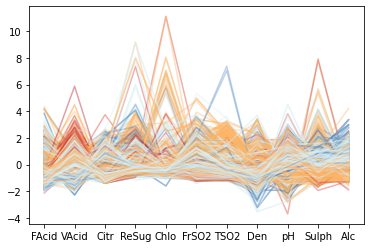

In [ ]:
import numpy as np
from numpy import exp

# fancy representations, analogous to wineq_norm.boxplot()
colour = 1.0/(1.0 + exp(-wineq_norm['Qual'].values))
parfig = plt.figure()
cols = wineq_norm.columns.tolist()[:-1]
for i in range(len(wineq_norm)):
  row = wineq_norm.iloc[i, :len(wineq_norm.columns)-1]
  plt.xticks(np.arange(len(row)), cols, rotation=85)
  row.plot(color=plt.cm.RdYlBu(colour[i]), alpha=.4)

          FAcid     VAcid      Citr  ...     Sulph       Alc      Qual
FAcid  1.000000 -0.256131  0.671703  ...  0.183006 -0.061668  0.124052
VAcid -0.256131  1.000000 -0.552496  ... -0.260987 -0.202288 -0.390558
Citr   0.671703 -0.552496  1.000000  ...  0.312770  0.109903  0.226373
ReSug  0.114777  0.001918  0.143577  ...  0.005527  0.042075  0.013732
Chlo   0.093705  0.061298  0.203823  ...  0.371260 -0.221141 -0.128907
FrSO2 -0.153794 -0.010504 -0.060978  ...  0.051658 -0.069408 -0.050656
TSO2  -0.113181  0.076470  0.035533  ...  0.042947 -0.205654 -0.185100
Den    0.668047  0.022026  0.364947  ...  0.148506 -0.496180 -0.174919
pH    -0.682978  0.234937 -0.541904  ... -0.196648  0.205633 -0.057731
Sulph  0.183006 -0.260987  0.312770  ...  1.000000  0.093595  0.251397
Alc   -0.061668 -0.202288  0.109903  ...  0.093595  1.000000  0.476166
Qual   0.124052 -0.390558  0.226373  ...  0.251397  0.476166  1.000000

[12 rows x 12 columns]


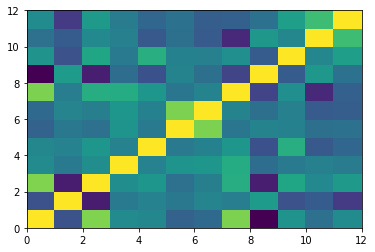

In [ ]:
correlation = wineq_pd.corr()
print(correlation)
plt.pcolor(correlation)

#### Sonar

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

rm = spark.read.format("csv").option("header", "False")\
     .option("inferSchema", "True")\
     .load(data_path + "sonar.all-data")

inputs = rm.columns[:-1]
string_indexer_class = StringIndexer(inputCol = "_c60", outputCol = 'label')
vecAssembler = VectorAssembler(inputCols=inputs, outputCol="features")
stages = [string_indexer_class, vecAssembler]

pipeline = Pipeline(stages = stages)
pipeline_mod = pipeline.fit(rm)
rm_transfd = pipeline_mod.transform(rm)
inp_rm = rm_transfd.select(['features', 'label'])
inp_rm.show(3)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.02,0.0371,0.04...|  1.0|
|[0.0453,0.0523,0....|  1.0|
|[0.0262,0.0582,0....|  1.0|
+--------------------+-----+
only showing top 3 rows



In [ ]:
from pyspark.ml.classification import LogisticRegression

train_rm, test_rm = inp_rm.randomSplit([0.7, 0.3], seed = 1234)
logr_rm = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
logr_mod_rm = logr_rm.fit(train_rm)

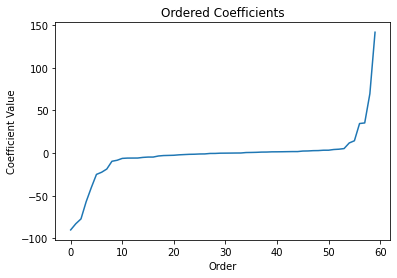

In [ ]:
weights_sorted = np.sort(logr_mod_rm.coefficients)
plt.plot(weights_sorted)
plt.ylabel('Coefficient Value')
plt.xlabel('Order')
plt.title('Ordered Coefficients')
plt.show()

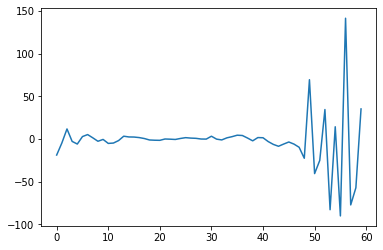

In [ ]:
n_weights = len(logr_mod_rm.coefficients)
plt.plot(list(zip(range(n_weights))), logr_mod_rm.coefficients)
plt.show()

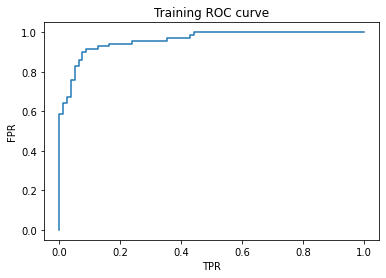

0.9602169981916819

In [ ]:
train_rm_summary = logr_mod_rm.summary
roc_rm = train_rm_summary.roc.toPandas()
plt.plot(roc_rm['FPR'], roc_rm['TPR'])
plt.title("Training ROC curve")
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.show()
train_rm_summary.areaUnderROC

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

logr_rm_preds = logr_mod_rm.transform(test_rm)
logr_rm_preds.select('rawPrediction', 'prediction', 'probability').show(4)
binclass_eval = BinaryClassificationEvaluator()
print('Test AOC:', binclass_eval.evaluate(logr_rm_preds))

+--------------------+----------+--------------------+
|       rawPrediction|prediction|         probability|
+--------------------+----------+--------------------+
|[-2.6869660519567...|       1.0|[0.06374685455394...|
|[-1.1541307052485...|       1.0|[0.23973540185759...|
|[-2.2167748375591...|       1.0|[0.09825418464345...|
|[-3.6104086770952...|       1.0|[0.02632884090092...|
+--------------------+----------+--------------------+
only showing top 4 rows

Test AOC: 0.8379629629629627


## 4. Spark unstructured API

#### Parallelize

Creates an RDD by distributing the contents of the parameter

In [ ]:
from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("spark-unstructured-api")
sc = SparkContext.getOrCreate(conf=conf)

rdd = sc.parallelize([2, 3, 5, 7,
                      11, 13, 17, 19,
                      23, 29, 31, 37,
                      41, 43, 47, 53])
rdd

ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:195

In [ ]:
type(rdd)

pyspark.rdd.RDD

#### Collect

Access the elements of an RDD and display them

In [ ]:
rdd.collect()

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53]

#### Take, First

`take(n)` returns a list containing the first n elements of an RDD,
`first()` returns the first element

In [ ]:
rdd.take(4)

[2, 3, 5, 7]

In [ ]:
rdd.first()

2

#### Count

Returns the number of elements in an RDD

In [ ]:
rdd.count()

16

#### Min, Max

Return the minimum and maximum of an RDD

In [ ]:
ds = sc.parallelize(['c', 'b', 'a', 'd'])
ds.min()

'a'

In [ ]:
ds.max()

'd'

#### Variance, Stdev, SampleVariance, SampleStdev

`variance`, `stdev` return the variance and standard deviation of
the elements of an RDD

`sampleVariance`, `sampleStdev` return the unbiased variance
and deviation

In [ ]:
ds = sc.parallelize([-2, -1, 0, 1, 2])
ds.variance()

2.0

In [ ]:
ds.stdev()

1.4142135623730951

In [ ]:
ds.sampleVariance()

2.5

In [ ]:
ds.sampleStdev()

1.5811388300841898

#### Map

Applies a function to each element of an RDD

In [ ]:
f = sc.textFile(data_path + "measurements.csv")
f.take(2)

['88118,2015-10-30,Ozone,Rimini,79',
 '927170,2015-10-08,Particulate matter,Ravenna,25']

In [ ]:
f.map(lambda l: l.split(",")).take(2)

[['88118', '2015-10-30', 'Ozone', 'Rimini', '79'],
 ['927170', '2015-10-08', 'Particulate matter', 'Ravenna', '25']]

#### MapValues

Applies a function to the values of the elements of an RDD
without changing keys or partitioning.
The value of an element of an RDD is the second component

In [ ]:
f.map(lambda l: l.split(",")).mapValues(lambda x: x[:4]).take(2)

[('88118', '2015'), ('927170', '2015')]

#### FlatMap

Applies a function to each element of an RDD, then “flattens”
the result, that is, eliminates nesting preserving values

In [ ]:
rdd = sc.parallelize([2, 3, 4])
sorted(rdd.flatMap(lambda x: [(x, x), (x, x)]).collect())

[(2, 2), (2, 2), (3, 3), (3, 3), (4, 4), (4, 4)]

#### Zip

Transposes two RDDs, concatenating the elements with the
same position

In [ ]:
benchmarks1 = sc.parallelize([1.83,  7.56,  7.30,  5.20,  8.95])
benchmarks2 = sc.parallelize([27.54, 57.48, 60.86, 33.25, 36.34])
benchmarks1.zip(benchmarks2).collect()

[(1.83, 27.54), (7.56, 57.48), (7.3, 60.86), (5.2, 33.25), (8.95, 36.34)]

#### ZipWithIndex

Associates with each element of a RDD a progressive integer
number, starting at 0. Equivalent to `zip()` with 0, 1, 2, 3...

In [ ]:
benchmarks1.zipWithIndex().collect()

[(1.83, 0), (7.56, 1), (7.3, 2), (5.2, 3), (8.95, 4)]

#### TakeSample

Returns a fixed cardinality sample of an RDD. First argument:
True -> replacement, False -> without replacement.
Suitable for small cardinality samples

In [ ]:
f = sc.textFile(data_path + "measurements.csv")
f.map(lambda l: l.split(",")).takeSample(False, 3)

[['657480', '2015-05-03', 'Ozone', 'Cesena', '32'],
 ['848686', '2015-03-23', 'Ozone', 'Ravenna', '63'],
 ['736202', '2015-02-27', 'Ozone', 'Modena', '62']]

#### Filter

Select the elements of an RDD that make an expression true

In [ ]:
f.map(lambda l: l.split(",")).filter(lambda x: x[1] >= '2015-03-01').take(3)

[['88118', '2015-10-30', 'Ozone', 'Rimini', '79'],
 ['927170', '2015-10-08', 'Particulate matter', 'Ravenna', '25'],
 ['697379', '2015-12-13', 'Ozone', 'Cesena', '0']]

#### Keys

Returns an RDD containing the keys of the RDD passed as a
parameter.
The term "key" does not imply the assumption or imposition of
any relational constraint

In [ ]:
rdd = sc.parallelize([[2.0, 5.0, 1.0],
                      [43.0, 10.0, 1.5],
                      [1., 0., 1.0],
                      [-1., 100., 1.5],
                      [2.0, 1.0, 1.0]])
rdd.keys().collect()

[2.0, 43.0, 1.0, -1.0, 2.0]

#### Intersection, Union

In [ ]:
rdd1 = sc.parallelize([4, 5, 2, 6, 0, -1])
rdd2 = sc.parallelize([0, 2, 9, -1, 0, -10, 4])

rdd1.intersection(rdd2).collect()

[4, 0, 2, -1]

In [ ]:
rdd1.union(rdd2).collect()

[4, 5, 2, 6, 0, -1, 0, 2, 9, -1, 0, -10, 4]

#### GroupByKey

Returns an RDD of lists [k, v] in which v is the list of values of
the elements with key k in the RDD that calls the method

In [ ]:
f = sc.textFile(data_path + "measurements.csv")
f1 = f.map(lambda l: l.split(","))
f2 = f1.map(lambda x: [x[3], x[:3]+[x[4]]])
f2.first()

['Rimini', ['88118', '2015-10-30', 'Ozone', '79']]

In [ ]:
f2.groupByKey().mapValues(list).first()

('Rimini',
 [['88118', '2015-10-30', 'Ozone', '79'],
  ['190115', '2015-02-04', 'Ozone', '59'],
  ['102991', '2015-04-02', 'Particulate matter', '41'],
  ['709920', '2015-12-23', 'Nitrogen dioxide', '14'],
  ['443801', '2015-12-26', 'Benzene', '80'],
  ['139230', '2015-06-17', 'Ozone', '58'],
  ['551808', '2015-03-04', 'Particulate matter', '34'],
  ['788825', '2015-12-31', 'Particulate matter', '89'],
  ['704559', '2015-06-15', 'Ozone', '24'],
  ['990483', '2015-11-28', 'Particulate matter', '16'],
  ['355684', '2015-06-29', 'Ozone', '93'],
  ['552771', '2015-11-22', 'Nitrogen dioxide', '24'],
  ['738018', '2015-01-17', 'Ozone', '43'],
  ['232472', '2015-03-05', 'Particulate matter', '90'],
  ['227592', '2015-09-17', 'Ozone', '67'],
  ['14418', '2015-04-14', 'Particulate matter', '94']])

#### Cartesian

In [ ]:
rdd = sc.parallelize([1, 2, 3])
rdd.cartesian(rdd).collect()

[(1, 1), (1, 2), (1, 3), (2, 1), (3, 1), (2, 2), (2, 3), (3, 2), (3, 3)]

#### Word Count

Count the occurrences of words in a text (`chaucer.txt`)

* The map function generates intermediate key-value pairs of
the form (w; 1), where w is a word in the document, in
parallel on all computing nodes.
* The intermediate pairs are grouped by key in parallel on all
nodes
* The reduce function sums all the 1’s associated to each w

In [ ]:
def word_count():
   conf = SparkConf().setAppName("SparkWordCount")
   sc = SparkContext.getOrCreate(conf=conf)
   input_file = sc.textFile(data_path + 'chaucer.txt')
   counts = input_file.flatMap(lambda line: line.split()) \
                     .map(lambda word: (word, 1)) \
                     .reduceByKey(lambda a, b: a + b)
   counts.saveAsTextFile('output-WordCount')
   #sc.stop()

word_count()
print("Execution done")

Execution done
